In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For demonstration, let's say wer CSV is called "ovarian_cancer.csv"
df = pd.read_csv("integrated_data.csv")
print("Initial shape:", df.shape)
print(df.head())


Initial shape: (2640, 45)
                                case_id  \
0  005a6517-2e5a-4ea3-ab36-531522723607   
1  005a6517-2e5a-4ea3-ab36-531522723607   
2  00630714-7ab3-44e1-afff-186300edae44   
3  00630714-7ab3-44e1-afff-186300edae44   
4  01abf2cf-541c-4610-8ce8-318016db6e59   

                                          follow_ups submitter_id_clin  \
0  [{'timepoint_category': 'Last Contact', 'follo...      TCGA-61-1740   
1  [{'timepoint_category': 'Last Contact', 'follo...      TCGA-61-1740   
2  [{'timepoint_category': 'Post Initial Treatmen...      TCGA-13-0761   
3  [{'timepoint_category': 'Post Initial Treatmen...      TCGA-13-0761   
4                                                NaN      TCGA-25-2390   

                                           diagnoses project.project_id  \
0  [{'figo_stage': 'Stage IIIC', 'synchronous_mal...            TCGA-OV   
1  [{'figo_stage': 'Stage IIIC', 'synchronous_mal...            TCGA-OV   
2  [{'morphology': 'Unknown', 'submitter_id':

In [3]:
# Example approach: drop columns > 80% missing
threshold = 0.8  # 80%
to_drop = [col for col in df.columns
           if df[col].isnull().sum()/df.shape[0] > threshold]
df.drop(columns=to_drop, inplace=True)
print("Columns to drop due to >80% missing values:", to_drop)
# Then we can do simple numeric imputation, e.g. median:
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

# For categorical, fill with "Unknown"
categorical_cols = df.select_dtypes(exclude=[np.number]).columns
for col in categorical_cols:
    df[col].fillna("Unknown")


Columns to drop due to >80% missing values: ['demographic.population_group', 'demographic.country_of_residence_at_enrollment', 'created_datetime', 'oct_embedded', 'days_to_sample_procurement', 'days_to_collection', 'initial_weight', 'annotations']


In [4]:
# Outlier Detection

Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

# Mark outliers (outside 1.5 * IQR)
outlier_mask = (df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR))

# Count how many outliers appear per column:
outlier_counts = outlier_mask.sum()
print("Outlier counts:\n", outlier_counts)

Outlier counts:
 demographic.age_at_index     1262
demographic.days_to_death     780
demographic.days_to_birth    1276
intermediate_dimension        635
sample_type_id                620
shortest_dimension            506
longest_dimension             675
dtype: int64


In [5]:
print("Number of rows left in df:", df.shape[0])

Number of rows left in df: 2640


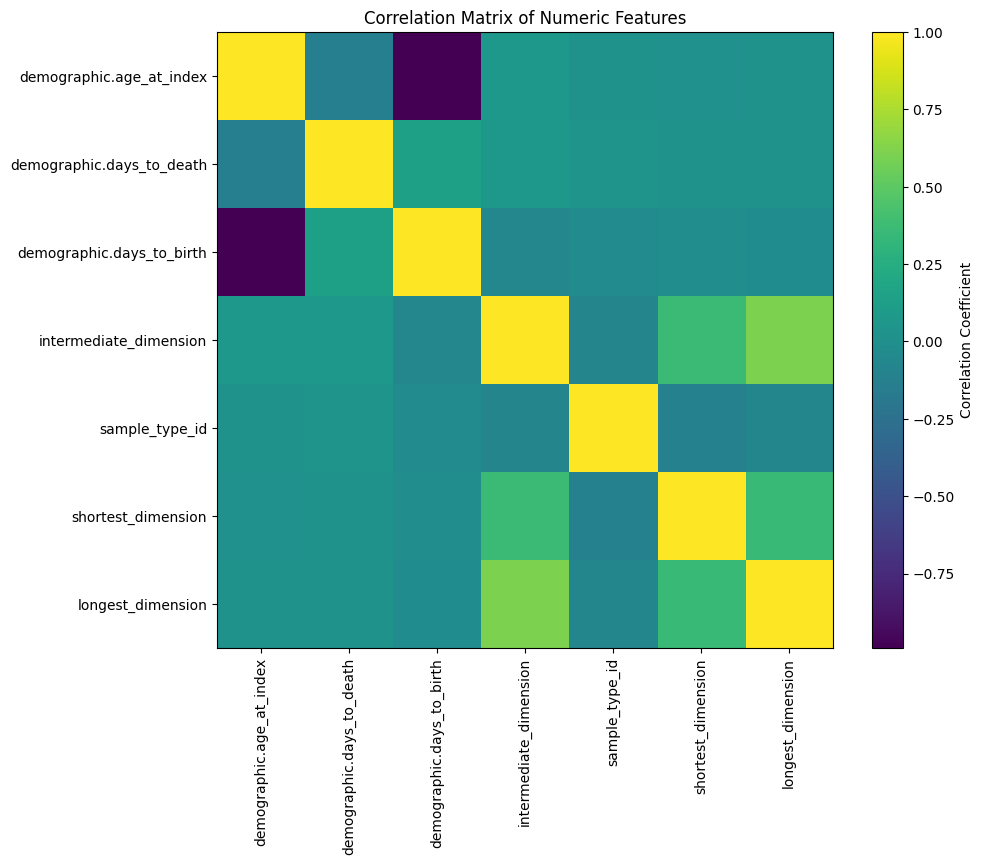

Highly correlated feature pairs: [('demographic.age_at_index', 'demographic.days_to_birth', np.float64(-0.9907431183078549))]


In [6]:
# Correlation Matrix & Visualization

corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
plt.imshow(corr_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Correlation Coefficient')
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=90)
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.title("Correlation Matrix of Numeric Features")
plt.show()

# Find pairs with correlation > 0.85 or < -0.85
high_corr_pairs = []
for i in range(len(numeric_cols)):
    for j in range(i+1, len(numeric_cols)):
        if abs(corr_matrix.iloc[i, j]) > 0.85:
            high_corr_pairs.append((numeric_cols[i], numeric_cols[j], corr_matrix.iloc[i, j]))


# high_corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
print("Highly correlated feature pairs:", high_corr_pairs)


In [7]:
encoded_df = pd.get_dummies(df, columns=['demographic.ethnicity',
                                         'demographic.race',
                                         'sample_type',
                                         'tumor_descriptor'],
                            drop_first=True)
print("Encoded shape:", encoded_df.shape)
print(encoded_df.head())

Encoded shape: (2640, 45)
                                case_id  \
0  005a6517-2e5a-4ea3-ab36-531522723607   
1  005a6517-2e5a-4ea3-ab36-531522723607   
2  00630714-7ab3-44e1-afff-186300edae44   
3  00630714-7ab3-44e1-afff-186300edae44   
4  01abf2cf-541c-4610-8ce8-318016db6e59   

                                          follow_ups submitter_id_clin  \
0  [{'timepoint_category': 'Last Contact', 'follo...      TCGA-61-1740   
1  [{'timepoint_category': 'Last Contact', 'follo...      TCGA-61-1740   
2  [{'timepoint_category': 'Post Initial Treatmen...      TCGA-13-0761   
3  [{'timepoint_category': 'Post Initial Treatmen...      TCGA-13-0761   
4                                                NaN      TCGA-25-2390   

                                           diagnoses project.project_id  \
0  [{'figo_stage': 'Stage IIIC', 'synchronous_mal...            TCGA-OV   
1  [{'figo_stage': 'Stage IIIC', 'synchronous_mal...            TCGA-OV   
2  [{'morphology': 'Unknown', 'submitter_id':

In [12]:
# Print all relevant columns in the dataframe
print("Relevant columns in the dataframe:", df.columns.tolist())
columns = df.columns.tolist()

# for col in columns:
#     print(col)
#     # print(df[col].value_counts())

Relevant columns in the dataframe: ['case_id', 'follow_ups', 'submitter_id_clin', 'diagnoses', 'project.project_id', 'demographic.demographic_id', 'demographic.ethnicity', 'demographic.gender', 'demographic.race', 'demographic.vital_status', 'demographic.age_is_obfuscated', 'demographic.updated_datetime', 'demographic.age_at_index', 'demographic.submitter_id', 'demographic.days_to_death', 'demographic.days_to_birth', 'demographic.state', 'intermediate_dimension', 'sample_type_id', 'tumor_descriptor', 'sample_id', 'pathology_report_uuid', 'submitter_id_bio', 'shortest_dimension', 'sample_type', 'specimen_type', 'updated_datetime', 'longest_dimension', 'state', 'is_ffpe', 'preservation_method', 'tissue_type', 'portions', 'composition', 'meta_submitter_id', 'meta_project.project_id', 'image_path']



### Columns
- `case_id`: Unique identifier for each case.
- `follow_ups`: Follow-up information for each case.
- `submitter_id_clin`: Clinical submitter ID.
- `diagnoses`: Diagnosis information for each case.
- `project.project_id`: Project ID.
- `demographic.demographic_id`: Demographic ID.
- `demographic.ethnicity`: Ethnicity of the patient.
- `demographic.gender`: Gender of the patient.
- `demographic.race`: Race of the patient.
- `demographic.vital_status`: Vital status of the patient.
- `demographic.age_is_obfuscated`: Whether the age is obfuscated.
- `demographic.updated_datetime`: Last updated datetime for demographic information.
- `demographic.age_at_index`: Age of the patient at the index date.
- `demographic.submitter_id`: Demographic submitter ID.
- `demographic.days_to_death`: Days to death from the index date.
- `demographic.days_to_birth`: Days to birth from the index date.
- `demographic.state`: State of the patient.
- `intermediate_dimension`: Intermediate dimension measurement.
- `sample_type_id`: Sample type ID.
- `tumor_descriptor`: Description of the tumor.
- `sample_id`: Sample ID.
- `pathology_report_uuid`: Pathology report UUID.
- `submitter_id_bio`: Biospecimen submitter ID.
- `shortest_dimension`: Shortest dimension measurement.
- `sample_type`: Type of sample.
- `specimen_type`: Type of specimen.
- `updated_datetime`: Last updated datetime for the sample.
- `longest_dimension`: Longest dimension measurement.
- `state`: State of the sample.
- `is_ffpe`: Whether the sample is FFPE.
- `preservation_method`: Method of preservation.
- `tissue_type`: Type of tissue.
- `portions`: Portions of the sample.
- `composition`: Composition of the sample.
- `meta_submitter_id`: Metadata submitter ID.
- `meta_project.project_id`: Metadata project ID.
- `image_path`: Path to the image.

# Image Preprocessing

In [39]:
import os
import cv2
import numpy as np

def load_patient_series(patient_series_path, desired_size=(256, 256)):
    """
    Loads all PNG slices from a given series folder, sorts them, resizes, 
    and stacks them into a 3D numpy array of shape [num_slices, height, width].
    """
    # List and sort all .png files
    slice_files = sorted([f for f in os.listdir(patient_series_path) if f.lower().endswith('.png')])
    
    slices = []
    for fname in slice_files:
        file_path = os.path.join(patient_series_path, fname)
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # CT slices are single-channel.
        # Resize to a standard dimension
        img_resized = cv2.resize(img, desired_size, interpolation=cv2.INTER_AREA)
        slices.append(img_resized)
    
    # Convert to float32 and stack into a 3D volume.
    volume = np.array(slices, dtype=np.float32)
    return volume

# Example usage for one series:
# series_path = "TCGA-OV/TCGA-09-0364/03-31-1989-NA-CT ABD PELV EN-98354/2.000000-AXIAL-59179"
# volume = load_patient_series(series_path)
# print("Loaded volume shape:", volume.shape)


In [41]:
def find_png_folders(root_dir):
    """
    Recursively searches through the root directory and returns a list of 
    subdirectories that contain at least one PNG file.
    """
    png_folders = []
    for current_root, dirs, files in os.walk(root_dir):
        if any(file.lower().endswith('.png') for file in files):
            png_folders.append(current_root)
    return png_folders

# Set your root directory (adjust the path as needed)
root_directory = "converted/TCGA-OV"  # Top-level folder with all patient data

# Get all series folders with PNG files
all_series_dirs = find_png_folders(root_directory)
print("Found", len(all_series_dirs), "series folders with PNG files.")


Found 26 series folders with PNG files.


In [42]:
def load_patient_series_normalized(patient_series_path, desired_size=(256, 256)):
    volume = load_patient_series(patient_series_path, desired_size)
    # Scale pixel values from 0 to 1
    volume_normalized = volume / 255.0
    return volume_normalized


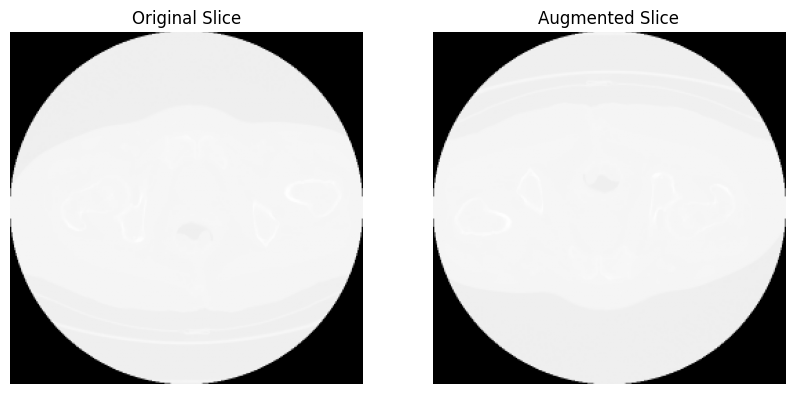

In [43]:

import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

# Define an augmentation pipeline for 2D slices
augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    ToTensorV2()
])

# Apply augmentation on a single slice for demonstration
# Assume 'volume_norm' is a normalized 3D volume from a series
slice_idx =  volume_norm.shape[0] // 2  # Choose a middle slice from a sample volume
slice_img = volume_norm[slice_idx]

augmented = augmentation_pipeline(image=slice_img)
aug_slice = augmented["image"].numpy().squeeze()  # Convert back to numpy and remove channel dimension

# Plot original vs. augmented slice
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(slice_img, cmap='gray')
plt.title("Original Slice")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(aug_slice, cmap='gray')
plt.title("Augmented Slice")
plt.axis('off')
plt.show()

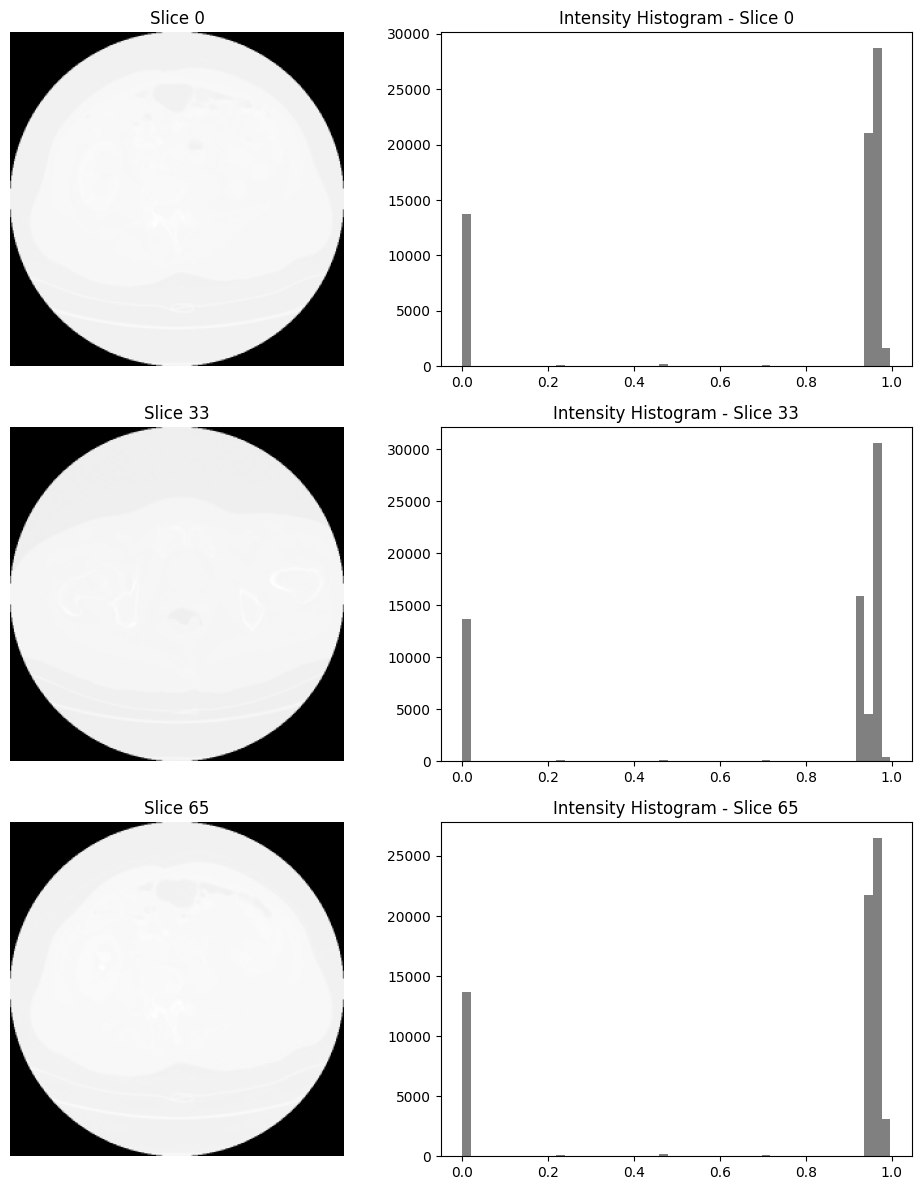

In [46]:
# Display a few sample slices and their intensity histograms
slice_indices = [0, volume_norm.shape[0]//2, volume_norm.shape[0]-1]
fig, axes = plt.subplots(len(slice_indices), 2, figsize=(10, 4*len(slice_indices)))
for i, idx in enumerate(slice_indices):
    slice_img = volume_norm[idx]
    axes[i, 0].imshow(slice_img, cmap='gray')
    axes[i, 0].set_title(f"Slice {idx}")
    axes[i, 0].axis('off')
    
    axes[i, 1].hist(slice_img.ravel(), bins=50, color='gray')
    axes[i, 1].set_title(f"Intensity Histogram - Slice {idx}")
plt.tight_layout()
plt.show()


In [45]:
def z_score_normalize(volume):
    mean_val = np.mean(volume)
    std_val = np.std(volume)
    return (volume - mean_val) / std_val

volume_zscore = z_score_normalize(volume_norm)
print("After z-score normalization: mean =", np.mean(volume_zscore), "std =", np.std(volume_zscore))


After z-score normalization: mean = -8.34465e-07 std = 1.0
